## 1. Setup

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [87]:
# Configuration
INPUT_FILE = '../../data/stressor-data.csv'
REDDIT_FILE = '../../data/stressed_anxious_cleaned.csv'
OUTPUT_FILE = '../../data/stressor-data-cleaned.csv' # Will output the cleaned data in a separate csv file, for now
MIN_WORD_COUNT = 3
MAX_TEXT_LENGTH = 5000

# Check if input file exists
print(os.path.exists(INPUT_FILE))
print(os.path.exists(REDDIT_FILE))

True
True


## 2. Create Combined Dataset

### 2.1 Load and check the original and Reddit data

In [88]:
# Load the dataset
df = pd.read_csv(INPUT_FILE)
df_reddit = pd.read_csv(REDDIT_FILE)

print(f"\nOriginal dataset shape: {df.shape}")
print(f"Original columns: {list(df.columns)}")

print(f"\nReddit dataset shape: {df_reddit.shape}")
print(f"Reddit columns: {list(df_reddit.columns)}")

# Preview the data
print(f"\nOriginal dataset tail: {df.tail()}")
print(f"\nReggit dataset tail: {df_reddit.tail()}")


Original dataset shape: (53043, 3)
Original columns: ['Unnamed: 0', 'statement', 'status']

Reddit dataset shape: (3999, 2)
Reddit columns: ['Text', 'is_stressed/anxious']

Original dataset tail:        Unnamed: 0                                          statement   status
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety

Reggit dataset tail:                                                    Text  is_stressed/anxious
3994  help me please  i thought i was doing okay emo...                    1
3995  help any of yall ever felt ill like body pain ...                    1
3996  i didn’t even know i was this stressed out  i ...                    1
3997 

### 2.2 Combine Datasets

In [89]:
# Drop index-like column from original dataset to match Reddit dataset
if 'Unnamed: 0' in df.columns:
   df = df.drop(columns=['Unnamed: 0'])

In [90]:
# Re-label Reddit dataset to match original dataset column names
df_reddit_relabeled = pd.DataFrame({
    'statement': df_reddit['Text'],
    'status': df_reddit['is_stressed/anxious'].map({1: 'Stress', 0: 'Normal'})
})
print(f"Re-labeled {len(df_reddit_relabeled):,} Reddit posts")

# Combine datasets
df_combined = pd.concat([df, df_reddit_relabeled], ignore_index=True)

print(f"Original dataset: {len(df):,} rows")
print(f"Reddit dataset: {len(df_reddit_relabeled):,} rows")
print(f"Combined dataset: {len(df_combined):,} rows")

Re-labeled 3,999 Reddit posts
Original dataset: 53,043 rows
Reddit dataset: 3,999 rows
Combined dataset: 57,042 rows


In [91]:
# Check for missing values
print("Missing values per column:")
print(df_combined.isnull().sum())

Missing values per column:
statement    596
status         0
dtype: int64


In [92]:
# Check label distribution
print("\nOriginal label distribution:")
print(df_combined['status'].value_counts())

# Label distribution as value counts
print("\nFinal label distribution:")
label_dist = df_combined['status'].value_counts()
print(label_dist)

# Label distribution as percentages
print("\nAs percentages:")
print((label_dist / len(df_combined) * 100).round(2))


Original label distribution:
status
Normal                  16351
Depression              15404
Suicidal                10653
Stress                   6668
Anxiety                  3888
Bipolar                  2877
Personality disorder     1201
Name: count, dtype: int64

Final label distribution:
status
Normal                  16351
Depression              15404
Suicidal                10653
Stress                   6668
Anxiety                  3888
Bipolar                  2877
Personality disorder     1201
Name: count, dtype: int64

As percentages:
status
Normal                  28.66
Depression              27.00
Suicidal                18.68
Stress                  11.69
Anxiety                  6.82
Bipolar                  5.04
Personality disorder     2.11
Name: count, dtype: float64


## 3. Data Cleaning

### 3.1 Remove rows with missing labels

In [93]:
# Remove rows with missing labels
initial_count = len(df_combined)
df_combined = df_combined.dropna(subset=['status'])
removed = initial_count - len(df_combined)

print(f"Removed {removed:,} rows with missing labels")
print(f"Remaining number of rows: {len(df_combined):,}")

Removed 0 rows with missing labels
Remaining number of rows: 57,042


### 3.2 Remove rows with missing, short, or too long statements

In [94]:
initial_count = len(df_combined)

# Remove rows with missing statements
df_combined = df_combined.dropna(subset=['statement'])

# Remove statements that are just whitespace
df_combined['statement'] = df_combined['statement'].astype(str)
df_combined = df_combined[df_combined['statement'].str.strip() != '']

removed = initial_count - len(df_combined)

print(f"Removed {removed:,} rows with empty statements")
print(f"Remaining number of rows: {len(df_combined):,}")

Removed 596 rows with empty statements
Remaining number of rows: 56,446


In [95]:
# Count words by splitting on whitespace
df_combined['word_count'] = df_combined['statement'].str.split().str.len()

# Remove rows with too short statements
df_combined = df_combined[df_combined['word_count'] >= MIN_WORD_COUNT]

# Drop the helper column
df_combined = df_combined.drop(columns=['word_count'])

removed = initial_count - len(df_combined)

print(f"\nRemoved {removed:,} statements with fewer than 3 words")
print(f"Remaining rows: {len(df_combined):,}")


Removed 1,487 statements with fewer than 3 words
Remaining rows: 55,555


In [96]:
# Trim statements to max allowed length
num_long_statements = df_combined[df_combined['statement'].str.len() > MAX_TEXT_LENGTH]
print(f"Found {len(num_long_statements):,} statements longer than {MAX_TEXT_LENGTH} characters")

df_combined['statement'] = df_combined['statement'].str[:MAX_TEXT_LENGTH]

# Print to show what happened
if len(num_long_statements) > 0:
    print(f"\nTrimmed {len(num_long_statements):,} statements to {MAX_TEXT_LENGTH} characters")
else:
    print(f"No statements needed trimming (max length already <= {MAX_TEXT_LENGTH})")

Found 241 statements longer than 5000 characters

Trimmed 241 statements to 5000 characters


### 3.3 Clean up labels

In [97]:
# Combine Anxiety and Stress labels into one label

# Check counts before combining
print("Before combining:")
print(f"Anxiety: {len(df_combined[df_combined['status'] == 'Anxiety']):,}")
print(f"Stress:  {len(df_combined[df_combined['status'] == 'Stress']):,}")

# Combine Anxiety and Stress into Stress
df_combined['status'] = df_combined['status'].replace({'Anxiety': 'Stress', 'Stress': 'Stress'})

print(f"\nAfter combining:")
print(f"Stress: {len(df_combined[df_combined['status'] == 'Stress']):,}")

Before combining:
Anxiety: 3,828
Stress:  6,350

After combining:
Stress: 10,178


In [98]:
# Keep only valid labels in the dataset (Normal, Depression, Suicidal, Stress)
VALID_LABELS = [
    'Normal', 'Depression', 'Suicidal',
    'Stress'
]

# Check to make sure which labels will be removed and how many rows they have
invalid_labels = df_combined[~df_combined['status'].isin(VALID_LABELS)]['status'].value_counts()
print("Labels to be removed:")
print(invalid_labels)

initial_count = len(df_combined)
df_combined = df_combined[df_combined['status'].isin(VALID_LABELS)]
removed = initial_count - len(df_combined)

print(f"\nRemoved {removed:,} rows with invalid labels")
print(f"Remaining number of rows: {len(df_combined):,}")

Labels to be removed:
status
Bipolar                 2777
Personality disorder    1077
Name: count, dtype: int64

Removed 3,854 rows with invalid labels
Remaining number of rows: 51,701


### 3.4 Check for character encoding issues

In [99]:
# Common encoding issues
encoding_fixes = {
    'â€™': "'",
    'â€œ': '"',
    'â€': '"',
    'â€"': '—',
    'â€"': '–',
    'â€¦': '...',
    'Â': '',
    'Ã©': 'é',
    'Ã¨': 'è',
    'Ã ': 'à',
    'Ã¢': 'â',
    'Ã´': 'ô',
    'Ã«': 'ë',
    'Ã¯': 'ï',
    'Ã¼': 'ü',
    'Ã±': 'ñ',
    'Ã§': 'ç',
    '\x00': '',
    '\ufeff': '',
    '\u2018': "'",
    '\u2019': "'",
    '\u201a': "'",
    '\u201c': '"',
    '\u201d': '"',
    '\u201e': '"',
    '\u2013': '-',
    '\u2014': '--',
    '\u2026': '...',
    '\u00a0': ' ',
}

# Check for encoding issues
issues_found = {}
for bad_char, good_char in encoding_fixes.items():
    count = df_combined['statement'].str.contains(bad_char, regex=False).sum()
    if count > 0:
        issues_found[bad_char] = count
        print(f"Encoding issues found: '{bad_char}' in {count:,} rows")

if not issues_found:
    print("No common encoding issues found")

# Fix issues
if issues_found:
    for bad_char, good_char in encoding_fixes.items():
        df_combined['statement'] = df_combined['statement'].str.replace(bad_char, good_char, regex=False)

# Normalize whitespaces
df_combined['statement'] = df_combined['statement'].str.replace(r'\s+', ' ', regex=True).str.strip()

Encoding issues found: 'â€™' in 3 rows
Encoding issues found: 'â€œ' in 33 rows
Encoding issues found: 'â€' in 120 rows
Encoding issues found: 'â€¦' in 7 rows
Encoding issues found: 'Â' in 36 rows
Encoding issues found: 'Ã©' in 1 rows
Encoding issues found: 'Ã ' in 1 rows
Encoding issues found: 'Ã«' in 1 rows
Encoding issues found: 'Ã¯' in 10 rows
Encoding issues found: 'Ã§' in 1 rows
Encoding issues found: '﻿' in 1 rows
Encoding issues found: '‘' in 109 rows
Encoding issues found: '’' in 4,308 rows
Encoding issues found: '‚' in 56 rows
Encoding issues found: '“' in 713 rows
Encoding issues found: '”' in 812 rows
Encoding issues found: '„' in 19 rows
Encoding issues found: '–' in 89 rows
Encoding issues found: '—' in 121 rows
Encoding issues found: '…' in 495 rows
Encoding issues found: ' ' in 54 rows


### 3.5 Remove rows with duplicate statement text

In [100]:
# Check how many duplicates exist
duplicate_count = df_combined['statement'].duplicated().sum()
print(f"Number of duplicate statements: {duplicate_count:,}")

# Remove the duplicated lines (keep the first occurrence of each)
initial_count = len(df_combined)
df_combined = df_combined.drop_duplicates(subset=['statement'], keep='first')
removed = initial_count - len(df_combined)

print(f"\nRemoved {removed:,} duplicate statements")
print(f"Remaining rows: {len(df_combined):,}")

Number of duplicate statements: 1,100

Removed 1,100 duplicate statements
Remaining rows: 50,601


### 3.6 Reset the row indeces

In [101]:
df_combined = df_combined.reset_index(drop=True)
print(f"Fixed row indeces\nNumber of rows in the new dataset: {len(df_combined):,}")
print(df_combined.head())
print(df_combined.tail())

Fixed row indeces
Number of rows in the new dataset: 50,601
                                           statement  status
0                                         oh my gosh  Stress
1  trouble sleeping, confused mind, restless hear...  Stress
2  All wrong, back off dear, forward doubt. Stay ...  Stress
3  I've shifted my focus to something else but I'...  Stress
4  I'm restless and restless, it's been a month n...  Stress
                                               statement  status
50596  help me please i thought i was doing okay emot...  Stress
50597  help any of yall ever felt ill like body pain ...  Stress
50598  i didn't even know i was this stressed out i h...  Stress
50599  headaches i dont know how to take a break i ju...  Stress
50600  brain shut down anyone else so far haven't met...  Stress


### 3.7 Create new label columns

In [102]:
# Numeric encoding column (if transformer will be used)
status_to_id = {status: idx for idx, status in enumerate(sorted(VALID_LABELS))}
id_to_status = {idx: status for status, idx in status_to_id.items()}

df_combined['status_id'] = df_combined['status'].map(status_to_id)
print(f"\nStatus mapping for numeric encoding (status_id column):")
for status, idx in sorted(status_to_id.items(), key=lambda x: x[1]):
    print(f"  {idx}: {status}")

# One-hot encoded columns (if RNN will be used)
for status in VALID_LABELS:
    # Create column name like status_Normal, status_Depression etc.
    col_name = f'status_{status.replace("/", "_").replace("-", "_")}'
    df_combined[col_name] = (df_combined['status'] == status).astype(int)

# Show final column structure
print(f"\nColumns: {list(df.columns)}")


Status mapping for numeric encoding (status_id column):
  0: Depression
  1: Normal
  2: Stress
  3: Suicidal

Columns: ['statement', 'status']


## 4. Check the Cleaned Dataset

In [103]:
# Dataset shape
print(f"Cleaned dataset shape: {df_combined.shape}")

# Features in the dataset
print(f"Columns: {list(df_combined.columns)}")

# Label distribution as value counts
print("\nFinal label distribution:")
label_dist = df_combined['status'].value_counts()
print(label_dist)

# Label distribution as percentages
print("\nAs percentages:")
print((label_dist / len(df_combined) * 100).round(2))

Cleaned dataset shape: (50601, 7)
Columns: ['statement', 'status', 'status_id', 'status_Normal', 'status_Depression', 'status_Suicidal', 'status_Stress']

Final label distribution:
status
Normal        15319
Depression    15062
Suicidal      10633
Stress         9587
Name: count, dtype: int64

As percentages:
status
Normal        30.27
Depression    29.77
Suicidal      21.01
Stress        18.95
Name: count, dtype: float64


## 5. Visualize the Cleaned Data

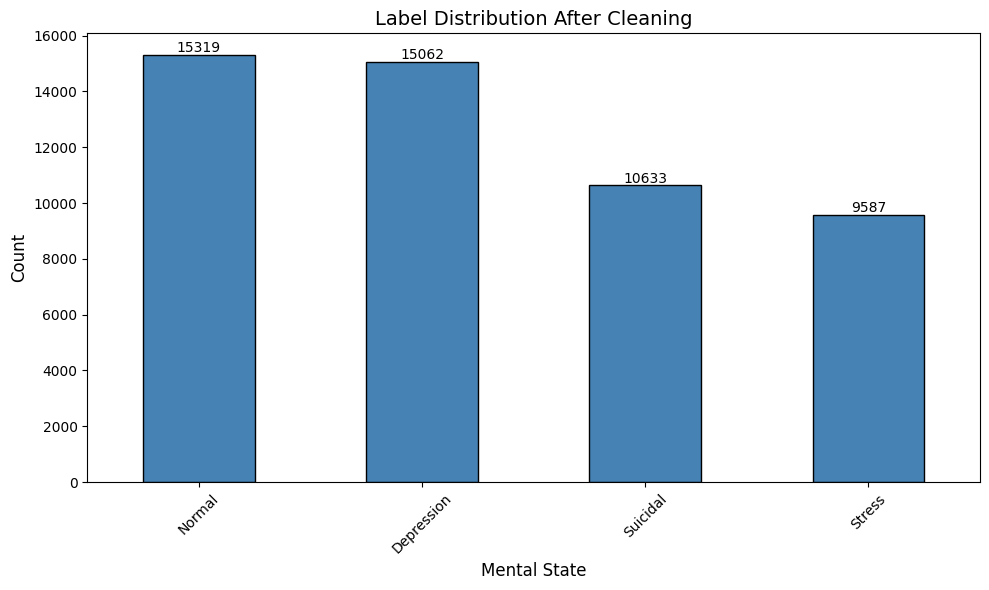

In [104]:
# Visualize label distribution
fig, ax = plt.subplots(figsize=(10, 6))
label_dist.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Label Distribution After Cleaning', fontsize=14)
ax.set_xlabel('Mental State', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', rotation=45)

for i, v in enumerate(label_dist):
    ax.text(i, v + 100, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Save the Cleaned Data

In [105]:
# Save new dataset to output file path
df_combined.to_csv(OUTPUT_FILE, index=False)
print(f"Cleaned dataset saved to '{OUTPUT_FILE}'")

Cleaned dataset saved to '../../data/stressor-data-cleaned.csv'
